# EnergyDistance: 

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
#plotting
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from dask.distributed import Client
import sklearn

In [3]:
# Please note that if we import the whole folder using __init__.py we would be running into ba Dask CanceledError due to different 
# imported Dask conflict, so we have to import only scEnergy script
import sys
sys.path.append("..")
import Templates.tools.scEnergy as eng 

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
adata = sc.read_h5ad(ED_file)

In [6]:
adata

AnnData object with n_obs × n_vars = 321358 × 33908
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class'
    var: 'Symbol'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
#adata.obs_names_make_unique()

## Filter adata

In [7]:
#adata = adata[adata.obs["DemuxAssignment_hashing"]!="POSITIVE_CONTROL"].copy()

In [ ]:
#adata= adata[~adata.obs.index.duplicated(keep='first')].copy()

## Subsampling NTCs

In [8]:
NTC = adata[adata.obs["gene_symbol"]=="NTC"].copy()

In [ ]:
#NTC= NTC[~NTC.obs.index.duplicated(keep='first')].copy()

In [9]:
if n is not None:
    NTC = NTC[NTC.obs.sample(n = n).index.copy()].copy()

In [10]:
NTC

AnnData object with n_obs × n_vars = 500 × 33908
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class'
    var: 'Symbol'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Create only genes dataframe

In [11]:
genes = [el for el in adata.obs['gene_symbol'].unique()]

In [12]:
genes.remove("NTC")

In [13]:
GENE = adata[adata.obs["gene_symbol"].isin(genes)].copy()

In [14]:
GENE

AnnData object with n_obs × n_vars = 313065 × 33908
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class'
    var: 'Symbol'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Concatenate dataframes

In [15]:
c = NTC.concatenate(GENE)

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [16]:
c

AnnData object with n_obs × n_vars = 313565 × 33908
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'batch'
    var: 'Symbol'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'

## Create dictionary with NTCs. Pool them first

### This is to calculate consistency among NTCs

In [17]:
ntcs_perturbations = [el for el in NTC.obs['DemuxAssignment_crispr'].unique()]

In [18]:
perturbations = [el for el in GENE.obs['DemuxAssignment_crispr'].unique()]

### Separate NTCs

In [19]:
pert = {}

for el in perturbations:
    v = eng.get_values_umap(c, 'DemuxAssignment_crispr', el)
    pert[el] = c[v].obsm[embeddings_key]

In [20]:
ntcs_pool = {}
W = eng.get_values_umap(c, 'gene_symbol', "NTC")
ntcs_pool['pool'] = c[W].obsm[embeddings_key]

## Calculate actual EnergyDistance as ed

In [21]:
ed = eng.run(
    client = Client(processes=True, n_workers=32),
    perturbations = pert, 
    controls = ntcs_pool,
    pool = 'Yes'
)

### Restart the client before new Computations with the refreshed client

In [22]:
#client = Client()
#client.restart()

In [23]:
PVAL = pd.DataFrame(ed).T.sort_values(by='pvalue')
PVAL

,pvalue,statistic,control_key
ENSG00000130165_2,0.0,0.754642,pool
ENSG00000189091_4,0.0,7.29074,pool
ENSG00000262633_3,0.0,5.582166,pool
ENSG00000006555_1,0.0,2.87281,pool
ENSG00000249104_3,0.0,3.171891,pool
...,...,...,...
ENSG00000181038_2,1.0,0.193917,pool
ENSG00000073464_3,1.0,0.171965,pool
ENSG00000165462_1,1.0,0.244916,pool
ENSG00000206069_2,1.0,0.571594,pool


#### p-value should be 1/1000 at minimum (for 1000 permutations)

In [ ]:
PVAL['pvalue'] = PVAL['pvalue'].replace(0,0.001)

In [24]:
PVAL['DemuxAssignment_crispr'] = PVAL.index

In [25]:
Pertubation_to_gene = adata.obs[["DemuxAssignment_crispr", "gene_symbol"]].drop_duplicates()

In [26]:
Pertubation_to_gene

,DemuxAssignment_crispr,gene_symbol
SAM24434749_rep1-AAACCCAAGATTAGCA,ENSG00000074771_1,NOX3
SAM24434749_rep1-AAACCCAAGATTGACA,ENSG00000157703_1,SVOPL
SAM24434749_rep1-AAACCCAAGCATTTCG,ENSG00000178015_2,GPR150
SAM24434749_rep1-AAACCCAAGCTGAGCA,ENSG00000186469_2,GNG2
SAM24434749_rep1-AAACCCAAGCTTACGT,ENSG00000133789_4,SWAP70
...,...,...
SAM24434749_rep20-CCGGTGAGTTGGGATG,ENSG00000167088_2,SNRPD1
SAM24434749_rep20-CTGTACCTCTTCGGTC,ENSG00000006059_3,KRT33A
SAM24434749_rep20-GAGGGATGTACAGTAA,ENSG00000113810_2,SMC4
SAM24434749_rep20-GTGAGCCTCTCCCTAG,ENSG00000030066_3,NUP160


In [27]:
df = PVAL.merge(Pertubation_to_gene, on="DemuxAssignment_crispr", how="left").reset_index(drop=True)

In [28]:
df

,pvalue,statistic,control_key,DemuxAssignment_crispr,gene_symbol
0,0.0,0.754642,pool,ENSG00000130165_2,ELOF1
1,0.0,7.29074,pool,ENSG00000189091_4,SF3B3
2,0.0,5.582166,pool,ENSG00000262633_3,ENSG00000262633_3
3,0.0,2.87281,pool,ENSG00000006555_1,TTC22
4,0.0,3.171891,pool,ENSG00000249104_3,USP17L17
...,...,...,...,...,...
20483,1.0,0.193917,pool,ENSG00000181038_2,METTL23
20484,1.0,0.171965,pool,ENSG00000073464_3,CLCN4
20485,1.0,0.244916,pool,ENSG00000165462_1,PHOX2A
20486,1.0,0.571594,pool,ENSG00000206069_2,TMEM211


In [48]:
df.to_csv(out_csv, index=False)

### Add the energy distance info to adata

In [31]:
ed_df = pd.DataFrame(ed).T.copy()

In [32]:
ed_df['DemuxAssignment_crispr'] = ed_df.index
ed_df=ed_df.reset_index(drop=True)

In [33]:
ed_df

,pvalue,statistic,control_key,DemuxAssignment_crispr
0,0.14,0.305698,pool,ENSG00000074771_1
1,0.135,0.27609,pool,ENSG00000157703_1
2,0.407,0.360027,pool,ENSG00000178015_2
3,0.863,0.301262,pool,ENSG00000186469_2
4,0.749,0.34788,pool,ENSG00000133789_4
...,...,...,...,...
20483,0.154,12.045974,pool,ENSG00000167088_2
20484,0.814,5.694522,pool,ENSG00000006059_3
20485,0.909,5.404447,pool,ENSG00000113810_2
20486,0.991,4.995029,pool,ENSG00000030066_3


In [ ]:
ed_df['pvalue'] = ed_df['pvalue'].replace(0,0.001)

In [34]:
ed_df = ed_df.rename(columns={"pvalue":"energy_distance_pvalue","statistic":"energy_distance_statistic","control_key":"energy_distance_control_key"})

In [35]:
df_uns = adata.obs.reset_index().merge(ed_df, on="DemuxAssignment_crispr", how="left").set_index('index')
df_uns.index.name = None

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/anndata/_core/anndata.py:782: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [36]:
b=['energy_distance_pvalue','energy_distance_statistic']#,'energy_distance_control_key','phenotype']

for el in b:
    df_uns[el] = df_uns[el].astype(float)

In [37]:
df_uns.head()

,Sample,Barcode,DemuxType_crispr,DemuxAssignment_crispr,DemuxType_hashing,DemuxAssignment_hashing,cellline,timepoint,gene_symbol,class,...,pct_counts_mt,total_counts_ribo,pct_counts_ribo,S_score,G2M_score,phase,SCN_class,energy_distance_pvalue,energy_distance_statistic,energy_distance_control_key
0,SAM24434749_rep1,AAACCCAAGATTAGCA,singlet,ENSG00000074771_1,singlet,SAM24434722,DLD1,day5,NOX3,target,...,2.777279,3603,21.565811,0.013953,-0.417101,S,Untreatedclus_DLD1,0.140,0.305698,pool
1,SAM24434749_rep1,AAACCCAAGATTGACA,singlet,ENSG00000157703_1,singlet,SAM24434748,DLD1,day5,SVOPL,target,...,2.748746,3126,32.671405,-0.023256,-0.065538,G1,Untreatedclus_DLD1,0.135,0.276090,pool
2,SAM24434749_rep1,AAACCCAAGCATTTCG,singlet,ENSG00000178015_2,singlet,SAM24434723,DLD1,day5,GPR150,target,...,0.827436,2198,23.930321,-0.516279,0.478009,G2M,DOXclus_DLD1,0.407,0.360027,pool
3,SAM24434749_rep1,AAACCCAAGCTGAGCA,singlet,ENSG00000186469_2,singlet,SAM24434722,DLD1,day5,GNG2,target,...,3.558796,4596,25.009523,-0.306977,0.322917,G2M,Untreatedclus_DLD1,0.863,0.301262,pool
4,SAM24434749_rep1,AAACCCAAGCTTACGT,singlet,ENSG00000133789_4,singlet,SAM24434748,DLD1,day5,SWAP70,target,...,1.521484,4062,26.524749,-0.079070,0.150174,G2M,Untreatedclus_DLD1,0.749,0.347880,pool


In [38]:
#df_uns.index = df_uns.index.astype(str)

In [ ]:
df_uns = df_uns.drop(columns='energy_distance_control_key')

In [39]:
df_uns['phenotype'] = 'No'
df_uns.loc[df_uns['energy_distance_pvalue']<=pVAL, 'phenotype'] = 'Yes'

In [40]:
PHENO = df_uns[df_uns['phenotype']=='Yes'].copy()
PHENO['DemuxAssignment_crispr'].nunique()

505

## Update the annadata object and write out the output

In [ ]:
df_uns_ED = df_uns[['energy_distance_pvalue','energy_distance_statistic','phenotype']].copy()
df_uns_ED = df_uns_ED.rename(columns={'phenotype': 'phenotype_@0.05'})

In [ ]:
if 'energy_distance' not in adata.uns:
    adata.uns["energy_distance"]={}

In [42]:
adata.uns["energy_distance"][key_uns]=df_uns_ED

In [ ]:
adata.write(ED_file)

## Data Tabulation

In [43]:
df_uns.groupby(['SCN_class', 'phenotype'])['DemuxAssignment_crispr'].size()

SCN_class             phenotype
DOXclus_CL34          No               13
                      Yes               2
DOXclus_COLO206F      No                1
                      Yes               0
DOXclus_DLD1          No            19923
                      Yes             816
DOXclus_HCA7          No               23
                      Yes               1
DOXclus_HT55          No                1
                      Yes               0
DOXclus_MDST8         No               64
                      Yes               2
DOXclus_SW480         No                4
                      Yes               0
DOXclus_SW1463        No               89
                      Yes               5
Untreatedclus_CL34    No                5
                      Yes               0
Untreatedclus_DLD1    No           292971
                      Yes            7084
Untreatedclus_RCM1    No               99
                      Yes               8
Untreatedclus_SKCO1   No               45
  

In [44]:
df_uns[(df_uns['phenotype']=='Yes')&(df_uns['SCN_class']=='DOXclus_DLD1')].groupby(
    ['gene_symbol'])['DemuxAssignment_crispr'].count().reset_index(name='cnt').sort_values(by='cnt', ascending=False)

,gene_symbol,cnt
244,TCF7L2,103
51,CTNNB1,45
148,MYC,44
31,CD81,18
73,EXOSC2,11
...,...,...
185,POLR2L,1
184,PLP1,1
94,HNMT,1
182,PILRA,1


In [45]:
df_uns[(df_uns['phenotype']=='Yes')&(df_uns['SCN_class']=='Untreatedclus_DLD1')].groupby(
    ['gene_symbol'])['DemuxAssignment_crispr'].count().reset_index(name='cnt').sort_values(by='cnt', ascending=False)

,gene_symbol,cnt
46,CD81,157
353,TCF7L2,141
403,WDR48,83
199,MSMO1,73
130,HMGCS1,62
...,...,...
269,PSMA2,1
42,CCDC57,1
240,PCNA,1
92,ENSG00000256500_4,1


In [46]:
df_uns[(df_uns['phenotype']=='Yes')].groupby(
    ['gene_symbol'])['DemuxAssignment_crispr'].count().reset_index(name='cnt').sort_values(by='cnt', ascending=False)[:30]

,gene_symbol,cnt
355,TCF7L2,244
46,CD81,177
405,WDR48,92
208,MYC,88
201,MSMO1,81
75,CTNNB1,77
132,HMGCS1,70
111,FARSB,58
183,LRRC75A,54
426,ZNF593OS,49


## Data Visulaization

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='energy_distance_pvalue', ylabel='Count'>

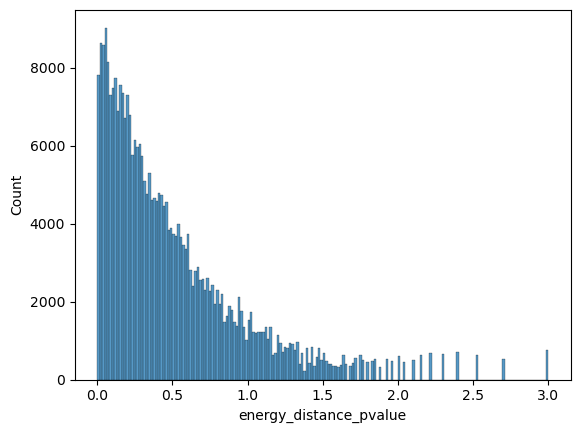

In [47]:
sns.histplot(-np.log10(df_uns['energy_distance_pvalue']))